In [14]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [ ]:
# Import packages
import pandas as pd                                                                                 # For loading the data into a DataFrame
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data

In [16]:
# Parameter
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
CLASSES = [1, 2, 3, 4, 5, 6]
LABEL = ['classvalue']
SPLIT = ['sample']
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#8B0100', '#B86401', '#008080', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALLFEATURES.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Bandung.tif'

/home/seviko/python/tf217/lib/python3.12/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


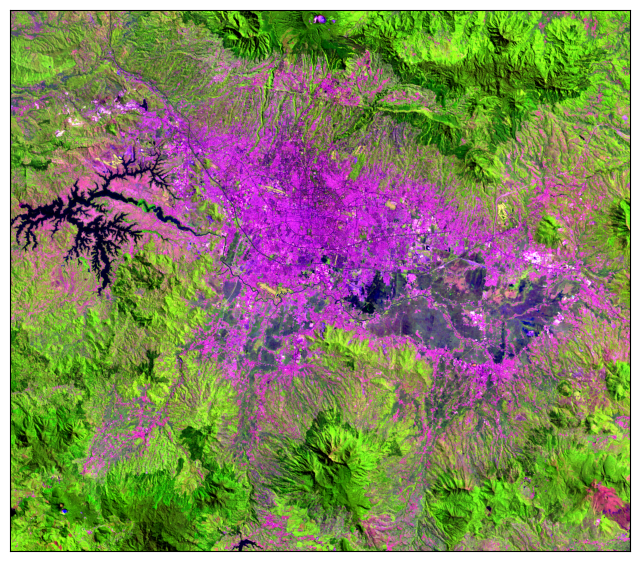

<Axes: >

In [17]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [18]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,NDVI,elevation,classvalue,sample
3761,0.060975,0.069789,0.091596,0.114641,0.182209,0.226264,0.206161,0.125437,-0.061674,-0.107853,-0.330938,0.107853,0.046488,0.227615,732,1,train
6470,0.032540,0.042275,0.083704,0.072855,0.303195,0.250876,0.137879,0.404599,0.374804,0.094426,-0.567309,-0.094426,0.290665,0.612525,4,2,train
6376,0.097935,0.118807,0.204937,0.257105,0.388170,0.356462,0.209502,0.160639,0.298939,0.042581,-0.308936,-0.042581,0.259663,0.203115,48,2,train
4443,0.048820,0.062267,0.087650,0.098457,0.155712,0.175540,0.151587,0.111874,0.013423,-0.059856,-0.279675,0.059856,0.073221,0.225263,670,1,train
20915,0.013482,0.019629,0.044722,0.028195,0.340622,0.138401,0.052161,0.573229,0.734402,0.422153,-0.767883,-0.422153,0.452555,0.847106,23,6,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24935,0.010210,0.014995,0.030491,0.019945,0.188465,0.081366,0.038274,0.352354,0.662398,0.396910,-0.721485,-0.396910,0.360185,0.808598,1430,6,train
7432,0.053275,0.065430,0.104191,0.112015,0.297337,0.327684,0.202476,0.313319,0.189793,-0.048552,-0.481027,0.048552,0.236169,0.452721,51,2,test
3471,0.043389,0.052780,0.074684,0.074106,0.205639,0.168844,0.131471,0.262137,0.220010,0.098256,-0.467158,-0.098256,0.124444,0.470187,690,1,train
23011,0.016563,0.018102,0.052615,0.026187,0.348542,0.155712,0.057675,0.588283,0.716039,0.382406,-0.737684,-0.382406,0.459434,0.860233,28,6,train


In [19]:
# from ydata_profiling import ProfileReport
# ProfileReport(samples[FEATURES], title="Pandas Profiling Report")

In [20]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy())
test_output = tf.keras.utils.to_categorical(test_label.to_numpy())

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (23814, 9, 1)
Test features: (4830, 9, 1)
Train label: (23814, 7)
Test label: (4830, 7)


In [21]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())

Label 1 4967
Label 2 1567
Label 3 4019
Label 4 2900
Label 5 3262
Label 6 7099


In [22]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.4
kernel = 2
pool = 2

# Make sequential model
model = tf.keras.Sequential([
  tf.keras.Input(input_shape),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  # MaxPooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.GlobalAveragePooling1D(),
  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(neuron * 2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(neuron * 1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(NUM_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 3, 128)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,271 (294.03 KB)

 Trainable params: 75,143 (293.53 KB)

 Non-trainable params: 128 (512.00 B)

In [23]:
# Train the model
from sklearn.utils.class_weight import compute_class_weight

train_output_flat = np.argmax(train_output, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_output_flat), y=train_output_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Compline the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, lr_callback],  
    epochs=500,
    class_weight=class_weights
)

{0: np.float64(0.7990738876585464), 1: np.float64(2.532865347798341), 2: np.float64(0.9875590943020652), 3: np.float64(1.3686206896551725), 4: np.float64(1.2167381974248928), 5: np.float64(0.5590928299760529)}
Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.1979 - loss: 11.0527 - val_accuracy: 0.3280 - val_loss: 10.1409 - learning_rate: 1.0000e-04
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.2818 - loss: 10.6363 - val_accuracy: 0.4493 - val_loss: 9.8134 - learning_rate: 1.0000e-04
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3522 - loss: 10.1680 - val_accuracy: 0.4692 - val_loss: 9.5041 - learning_rate: 1.0000e-04
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4127 - loss: 9.6857 - val_accuracy: 0.4706 - val_loss: 9.2098 - learning_rate: 1.0000e-04
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4635 - loss: 9.1633 - val_accuracy: 0.4716 - val_loss: 8.9199 - learning_rate: 1.0000e-04
Epoch 

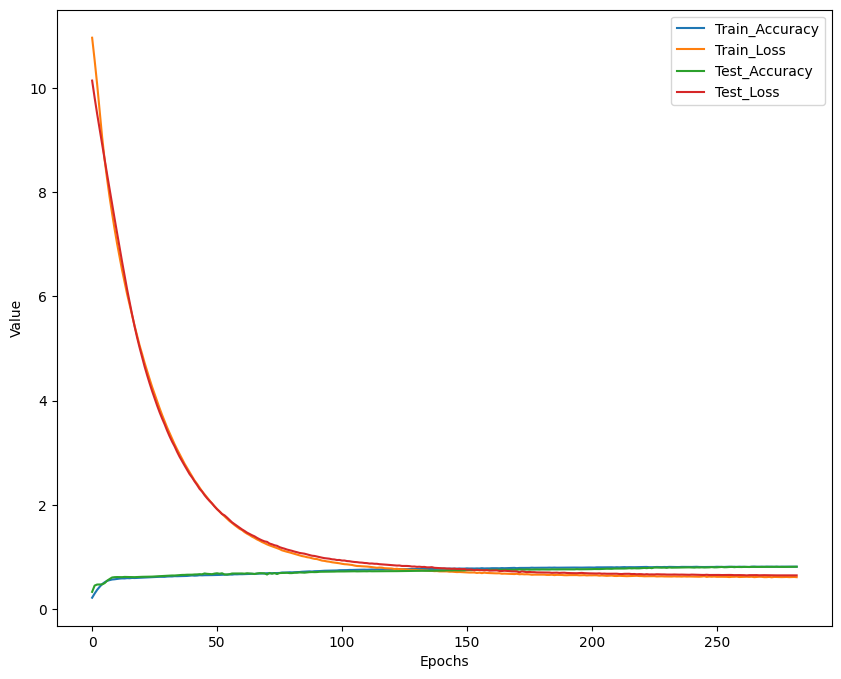

In [24]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       872
           2       0.71      0.87      0.78       307
           3       0.71      0.75      0.73       710
           4       0.99      0.98      0.98       531
           5       0.91      0.41      0.57       967
           6       0.72      0.92      0.81      1443

    accuracy                           0.81      4830
   macro avg       0.83      0.82      0.81      4830
weighted avg       0.83      0.81      0.80      4830



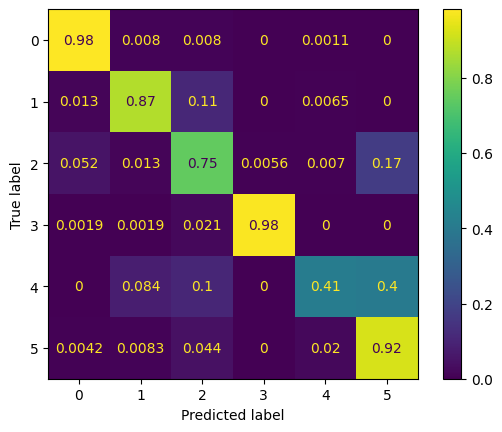

In [25]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

2024-11-27 08:46:26.910938: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[62195,64,1,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[62195,128,1,3]{3,2,1,0}, f32[64,128,1,2]{3,2,1,0}, f32[64]{0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-27 08:46:29.584513: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.681873558s
Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[62195,64,1,2]{3,2,1,0}, u8[0]{0}) custom-call(f32[62195,128,1,3]{3,2,1,0}, f32[64,128,1,2]{3,2,1,0}, f32[64]{0}), window={size=1x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step


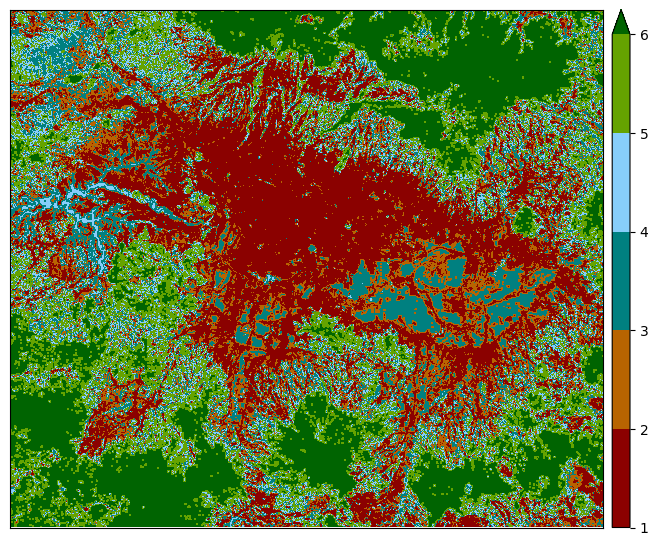

<Axes: >

In [26]:
# Predict image using the model
image_input = []
for x in range(NUM_OF_BANDS):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)